In [1]:
# Import libraries
from google.colab import drive
import os
import sys
import pickle
import numpy as np
import pandas as pd
from scipy import interp
from itertools import cycle
import math 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras_preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils
from tensorflow.keras.applications import  MobileNet, MobileNetV2

In [2]:
# Connect with Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# import utils
path = "/content/drive/My Drive/DataScience/"
sys.path.append(os.path.abspath(path))
from utils import load_data, save_data, concat_dataset

In [4]:
class_names = ['indoor selfie', 'outdoor selfie', 'indoor pose', 'outdoor pose', 'no human']

# Load Data

In [7]:
# Load the data
X = load_data('/content/drive/My Drive/DataScience/Dataset concat/', 'dataset.pickle')
y = load_data('/content/drive/My Drive/DataScience/Dataset concat/', 'labels.pickle')

# Preprocess Data

In [8]:
# Check datatype and value range
print(X.dtype)
print(np.max(X))
print(np.min(X))

float32
255.0
0.0


In [9]:
# Normalize the dataset:
X = X/255.0

In [10]:
# Split the data on train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3851, 224, 224, 3), (963, 224, 224, 3), (3851,), (963,))

In [11]:
# Save original labels
y_train1 = y_train
y_test1 = y_test

In [12]:
# One hot encode outputs
y_train = y_train.reshape(-1,1)
y_train.shape

y_test = y_test.reshape(-1,1)
y_test.shape

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

# Visualize Data

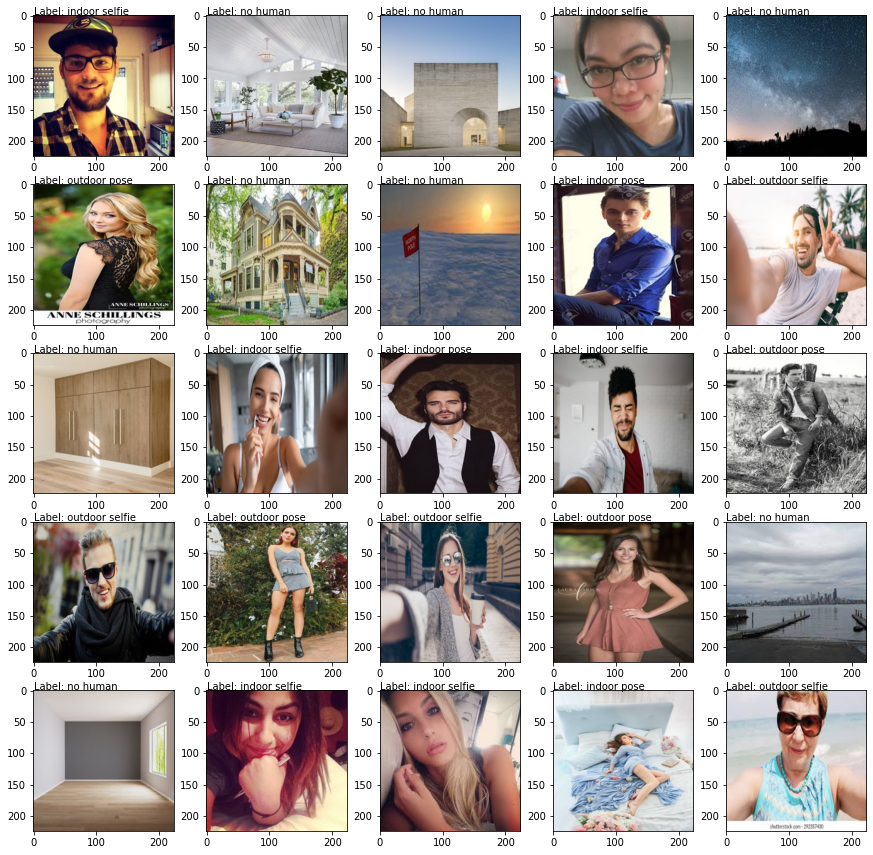

In [13]:
# Visualizing the first 25 images from the training set:
fig = plt.figure(figsize = (15, 15))

for i in range(25):
    ax1 = fig.add_subplot(5, 5, i+1)
    ax1.imshow(X_train[i])
    title = "Label: " + str(class_names[y_train1[i]])
    ax1.text(0, -1, title, size = 10)

plt.show()

In [15]:
# Visualize data distribution
y_df = pd.DataFrame(y, columns = ['categories'])

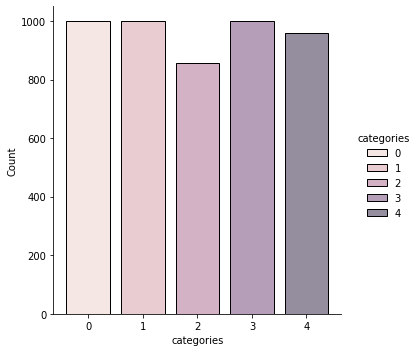

In [16]:
sns.displot(y_df, x = "categories", shrink = .8, hue = "categories", discrete = True)

# Model


In [19]:
# Set hyper-parameters for the model
epochs = 30
loss = 'categorical_crossentropy'
optimizer = 'sgd'
metrics = ['accuracy']

In [31]:
# Data augmentation
datagen = ImageDataGenerator(
   rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X_train)

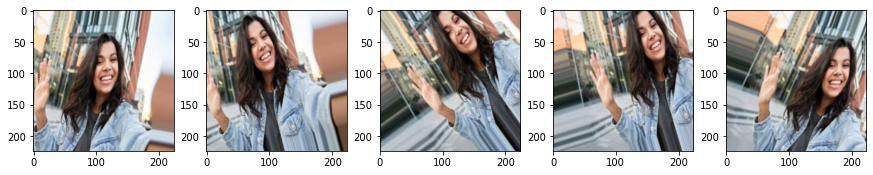

In [22]:
# Visualise few augmented examples
aug = []
dirname = '/content/drive/My Drive/DataScience/Augmentation example/'

for filename in os.listdir(dirname):
  if filename.endswith('jpg'):
    filedir = dirname + filename

    img = cv2.imread(filedir)
    img_resized = img_to_array(array_to_img(img, scale = False).resize((224, 224))) #default is linear interpolation
    img_color = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    aug.append(img_color/255)

fig = plt.figure(figsize = (15, 15))

for i in range(5):
    ax1 = fig.add_subplot(5, 5, i+1)
    ax1.imshow(aug[i])

plt.show()

In [23]:
# Create the model

# Freeze convolutional base
conv_base = MobileNet(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_base.trainable = False

# Add classifier on top of the conv base
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

17227776/17225924 [==============================] - 0s 0us/step


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               12845312  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 16,075,461
Trainable params: 12,846,597
Non-trainable params: 3,228,864
_________________________________________________________________


In [25]:
# Compile the model
model.compile(loss = loss, optimizer = optimizer, metrics = metrics)

## Model train and save


In [27]:
# Define early stopping criterion and save best model
callback_1 = ModelCheckpoint(filepath = '/content/drive/My Drive/DataScience/Models/best_model_mobileV2.pt', monitor='val_accuracy', save_best_only = True, mode='max', verbose=1)
callback_2 = EarlyStopping(patience = 15)
callback_list = [callback_1, callback_2]

In [32]:
# Train the model
training_history = model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data = (X_test, y_test), 
            steps_per_epoch = len(X_train)/32, epochs=epochs, callbacks = callback_list, verbose = 1)

## Model evaluate


In [32]:
# Plot accuracy
plt.figure() 
plt.plot(training_history.history['accuracy'], label = 'train')
plt.plot(training_history.history['val_accuracy'], label = 'validation')

plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plot loss function
plt.figure()
plt.plot(training_history.history['loss'],label = 'train')
plt.plot(training_history.history['val_loss'],label = 'validation')

plt.legend()
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

31/31 [==============================] - 40s 1s/step - loss: 0.1684 - accuracy: 0.9533
Validation accuracy for 95.33% 

Classification report 

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       219
           1       0.93      0.97      0.95       197
           2       0.93      0.95      0.94       171
           3       0.95      0.95      0.95       183
           4       1.00      0.98      0.99       193

    accuracy                           0.95       963
   macro avg       0.95      0.95      0.95       963
weighted avg       0.95      0.95      0.95       963

Confusion matrix 



Text(0.5, 1.0, 'Confusion Matrix')

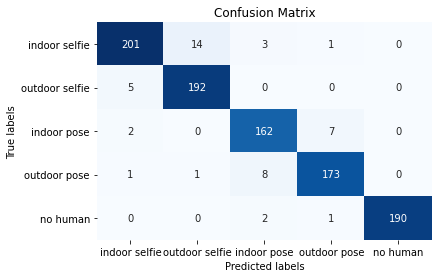

In [33]:
# Models highest score on validation
model = load_model('/content/drive/My Drive/DataScience/Models/best_model_mobile.pt')
score = model.evaluate(X_test, y_test)
print("Validation accuracy for %.2f%% \n" % (score[1]*100))

# Get probabilities
pred = model.predict(X_test)

# Get predicted class
predictions = []
for i in range(y_test1.shape[0]):
  predictions.append(np.argmax(pred[i]))

print('Classification report \n')
print(classification_report(y_test1, predictions))

print('Confusion matrix \n')
cm = confusion_matrix(y_test1, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

ax= plt.subplot()
sns.heatmap(df_cm, cmap='Blues', annot=True, cbar =False, fmt='g')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

In [38]:
# Get the wrong predictions
mistakes = np.array([i for i, _ in enumerate(predictions) if predictions[i]!=y_test1[i]])

X_mistakes = X_test[mistakes]
y_mistakes = y_test1[mistakes]
predictions = np.array(predictions)
pred_mistakes = predictions[mistakes]

In [39]:
# Calculate ROC AUC Score
n_classes = y_train.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

lw =2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


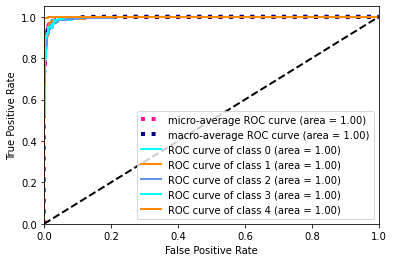

In [40]:
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [41]:
# Show wrongly predicted images
fig = plt.figure(figsize = (20, 20))
n = math.ceil(math.sqrt(pred_mistakes.shape[0]))

for i in range(pred_mistakes.shape[0]):
    ax1 = fig.add_subplot( n, n, i+1)
    ax1.imshow(array_to_img(X_mistakes[i]))
    title = str(i) + ' ' + str(class_names[y_mistakes[i]]) + '/ ' + str(class_names[pred_mistakes[i]]) # i + true label / predicted
    ax1.text(0, -2, title, size = 10)
    ax1.set_xticks([])
    ax1.set_yticks([])

plt.show()

Output hidden; open in https://colab.research.google.com to view.